#### B3和CNN联合模型;得分:0.871
##### np.argmax(model.predict(img)*0.5+model1.predict(img)*0.5)

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input, Model
from keras.layers import Dense, Dropout, Flatten, add
import keras

In [3]:
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam

In [4]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

os.listdir(BASE_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [5]:
train_data = pd.read_csv(BASE_DIR+'train.csv')
samp_subm = pd.read_csv(BASE_DIR+'sample_submission.csv')

print(train_data)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [6]:
print('number of train data:', len(train_data))
print('number of train images:', len(os.listdir(BASE_DIR+'train_images/')))
print('number of test images:', len(os.listdir(BASE_DIR+'test_images/')))

number of train data: 21397
number of train images: 21397
number of test images: 1


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df['label'] = train_df['label'].astype(str)

batch_size=16
input_size = (300, 300)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.1,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    
    preprocessing_function=None,
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    x_col="image_id",
    y_col="label",
    batch_size=batch_size,
    target_size=input_size,
    class_mode="sparse", 
    subset = "training"
)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.1)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    x_col="image_id",
    y_col="label",
    batch_size=batch_size,
    target_size=input_size ,
    class_mode="sparse", 
    subset="validation")

Found 19258 validated image filenames belonging to 5 classes.
Found 2139 validated image filenames belonging to 5 classes.


In [8]:
BATCH_SIZE=16
STEPS_PER_EPOCH = len(train_df)*0.9 // BATCH_SIZE
VALIDATION_STEPS = len(train_df)*0.1 // BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

1203.0
133.0


In [9]:
from tensorflow.keras.applications import EfficientNetB3 

EfficientNetB0_dir="../input/tfkerasefficientnetimagenetnotop/efficientnetb3_notop.h5"
EfficientNetB3 = EfficientNetB3(weights=EfficientNetB0_dir, include_top = False, input_shape = (300,300,3))
EfficientNetB3.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(EfficientNetB3)
    
model.add(layers.GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(layers.Dense(5, activation = "softmax"))
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [12]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    steps_per_epoch = len(train_df)*0.9//batch_size,
    validation_steps = len(train_df)*0.1//batch_size, 
    epochs = 15,
    verbose=1,
    callbacks = callbacks,
    
)

Epoch 1/15
1203/1203 [==============================] - 882s 734ms/step - loss: 0.6432 - accuracy: 0.7695 - val_loss: 1.1907 - val_accuracy: 0.5150
Epoch 2/15
1203/1203 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8362
Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1203/1203 [==============================] - 779s 647ms/step - loss: 0.4693 - accuracy: 0.8362 - val_loss: 1.3712 - val_accuracy: 0.4272
Epoch 3/15
1203/1203 [==============================] - 808s 671ms/step - loss: 0.3931 - accuracy: 0.8634 - val_loss: 0.4530 - val_accuracy: 0.8496
Epoch 4/15
1203/1203 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8702
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1203/1203 [==============================] - 808s 671ms/step - loss: 0.3711 - accuracy: 0.8702 - val_loss: 1.2088 - val_accuracy: 0.5916
Epoch 5/15
1203/1203 [==============================] - ETA: 0s - loss: 0.

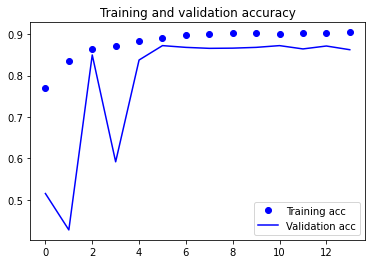

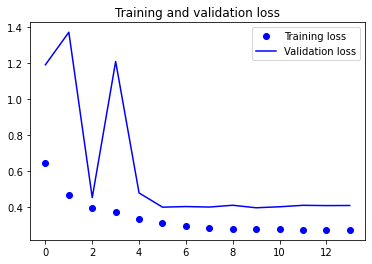

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras import layers
from keras import models
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(300, 300, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5)) #添加dropout 正则化
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(5, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)      

In [16]:
import tensorflow as tf
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model1.fit_generator(
    train_generator,
    validation_data = valid_generator,
    steps_per_epoch = len(train_df)*0.9//batch_size,
    validation_steps = len(train_df)*0.1//batch_size, 
    epochs = 15,
    verbose=1
)

Epoch 1/15
1203/1203 [==============================] - 658s 547ms/step - loss: 1.0716 - accuracy: 0.6256 - val_loss: 0.9435 - val_accuracy: 0.6504
Epoch 2/15
1203/1203 [==============================] - 614s 511ms/step - loss: 0.9457 - accuracy: 0.6533 - val_loss: 0.8520 - val_accuracy: 0.6795
Epoch 3/15
1203/1203 [==============================] - 635s 528ms/step - loss: 0.8743 - accuracy: 0.6767 - val_loss: 0.7964 - val_accuracy: 0.6945
Epoch 4/15
1203/1203 [==============================] - 632s 525ms/step - loss: 0.8369 - accuracy: 0.6846 - val_loss: 0.8131 - val_accuracy: 0.6950
Epoch 5/15
1203/1203 [==============================] - 629s 523ms/step - loss: 0.8057 - accuracy: 0.6967 - val_loss: 0.7694 - val_accuracy: 0.7091
Epoch 6/15
1203/1203 [==============================] - 625s 520ms/step - loss: 0.7818 - accuracy: 0.7025 - val_loss: 0.7350 - val_accuracy: 0.7223
Epoch 7/15
1203/1203 [==============================] - 637s 530ms/step - loss: 0.7615 - accuracy: 0.7162 - val_

In [18]:
sample = "../input/cassava-leaf-disease-classification/sample_submission.csv"
sample_df = pd.read_csv(sample)
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [19]:
INPUT_PATH = "../input/cassava-leaf-disease-classification/"
test_images_path = INPUT_PATH+"test_images/"

In [20]:
import cv2
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

In [21]:
predictions = []
for image_id in sample_df.image_id:
    img = Image.open(os.path.join(test_images_path+image_id))
    img = img.resize((300,300))
    img = np.expand_dims(img, axis=0)
    img = img/255.
    predictions.append(#)

sample_df["label"] = predictions

In [22]:
sample_df.to_csv("submission.csv", index = False)